✅ Files found. Loading data...
Layout loaded: 357 locations.
Allocations loaded: 191 records.
Data processing complete.
[Visualizer] Drawing Top View for 37 stacks.


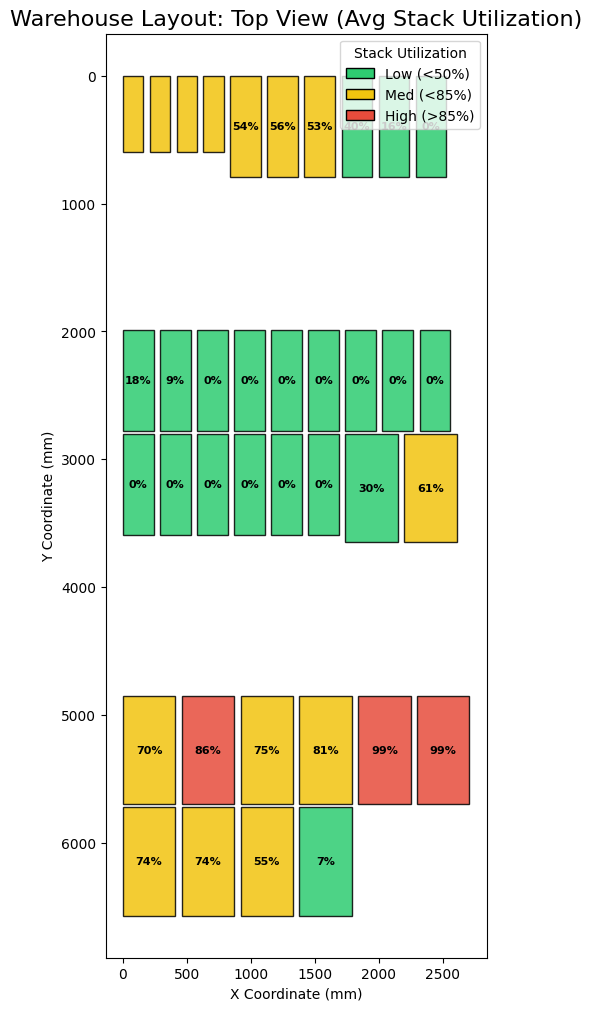

Visualizing Full Warehouse Range: A1-00001 to A3-00090
[Visualizer] Drawing Front View for 9 rack columns.


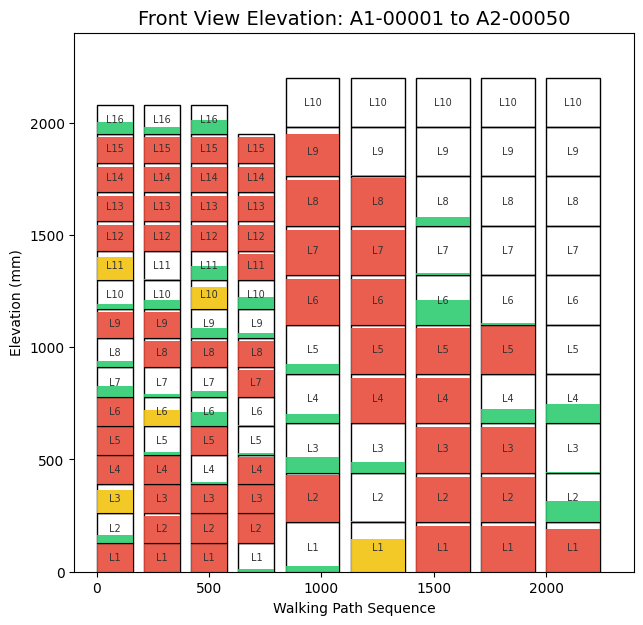

In [2]:
# %% [markdown]
# # Warehouse Visualization
# This notebook visualizes the warehouse layout using:
# 1. `locations_dummy.csv`: Physical layout coordinates.
# 2. `baseline_allocation_one_sku_per_bin.csv`: Inventory and utilization data.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

# Import the provided visualizer module
try:
    import warehouse_visualizer as vis
except ImportError:
    print("❌ Error: 'warehouse_visualizer.py' not found. Please ensure the file is in the directory.")

# %% [markdown]
# ### 1. Load Data
# Reading directly from the CSV files in the current directory.

# %%
# File Definitions
layout_file = 'locations_dummy.csv'
alloc_file = 'baseline_allocation_one_sku_per_bin.csv'

# Check if files exist
if not os.path.exists(layout_file) or not os.path.exists(alloc_file):
    print(f"❌ Error: Please ensure '{layout_file}' and '{alloc_file}' are in the folder.")
else:
    print("✅ Files found. Loading data...")

    # Load DataFrames
    df_loc = pd.read_csv(layout_file)
    df_alloc = pd.read_csv(alloc_file)
    
    # Optional: Clean ID columns to ensure strings match (remove whitespace)
    df_loc['loc_inst_code'] = df_loc['loc_inst_code'].astype(str).str.strip()
    df_alloc['LOC_INST_CODE'] = df_alloc['LOC_INST_CODE'].astype(str).str.strip()

    print(f"Layout loaded: {len(df_loc)} locations.")
    print(f"Allocations loaded: {len(df_alloc)} records.")

# %% [markdown]
# ### 2. Merge & Process
# We merge the physical layout with the allocation data to map `UTILIZATION_%` to the `x, y, z` coordinates.

# %%
# Merge: Left Join on Location ID
# We keep ALL layout locations (left), even if they are empty in the allocation file.
df_merged = pd.merge(
    df_loc, 
    df_alloc[['LOC_INST_CODE', 'UTILIZATION_%']], 
    left_on='loc_inst_code', 
    right_on='LOC_INST_CODE', 
    how='left'
)

# 1. Handle Empty Locations (NaN) -> Set to 0%
df_merged['UTILIZATION_%'] = df_merged['UTILIZATION_%'].fillna(0.0)

# 2. Normalize for Visualizer
# The visualizer expects a float between 0.0 and 1.0, but the CSV has 0-100.
df_merged['utilization'] = df_merged['UTILIZATION_%'] / 100.0

# 3. Clean up
if 'LOC_INST_CODE' in df_merged.columns:
    df_merged = df_merged.drop(columns=['LOC_INST_CODE'])

print("Data processing complete.")
df_merged[['loc_inst_code', 'x', 'y', 'z', 'UTILIZATION_%', 'utilization']].head()

# %% [markdown]
# ### 3. Top View (Heatmap)
# Displays the warehouse footprint. Colors represent the **Average Utilization** of the vertical stack at that coordinate.

# %%
def plot_layout_top_view(df_data):
    """
    Plots the physical layout footprint. 
    Colors represents the AVERAGE utilization of the stack (Z-axis).
    """
    fig, ax = plt.subplots(figsize=(14, 12))
    ax.set_facecolor('white')
    
    # Group by X/Y to handle the vertical stack
    # We take the FIRST width/depth (physical dim) and MEAN utilization
    stack_data = df_data.groupby(['x', 'y']).agg({
        'width': 'first',
        'depth': 'first',
        'utilization': 'mean'
    }).reset_index()

    print(f"[Visualizer] Drawing Top View for {len(stack_data)} stacks.")
    
    for _, row in stack_data.iterrows():
        # Get color based on traffic light logic
        avg_util = row['utilization']
        color = vis._get_traffic_light_color(avg_util)
        
        # Draw footprint
        rect = patches.Rectangle(
            (row['x'], row['y']), 
            row['width'], 
            row['depth'],
            linewidth=1, 
            edgecolor='black', 
            facecolor=color,
            alpha=0.85
        )
        ax.add_patch(rect)
        
        # Annotation: Show Avg % if bin is large enough
        if row['width'] > 200:
            ax.text(
                row['x'] + row['width']/2, 
                row['y'] + row['depth']/2, 
                f"{int(avg_util*100)}%", 
                ha='center', va='center', fontsize=8, fontweight='bold', color='black'
            )
        
    # Axis settings
    ax.autoscale()
    ax.set_aspect('equal')
    ax.invert_yaxis() # Warehouse convention
    ax.set_title("Warehouse Layout: Top View (Avg Stack Utilization)", fontsize=16)
    ax.set_xlabel("X Coordinate (mm)")
    ax.set_ylabel("Y Coordinate (mm)")
    
    # Legend
    legend_elements = [
        patches.Patch(facecolor=vis.COLORS['low'], edgecolor='black', label='Low (<50%)'),
        patches.Patch(facecolor=vis.COLORS['med'], edgecolor='black', label='Med (<85%)'),
        patches.Patch(facecolor=vis.COLORS['high'], edgecolor='black', label='High (>85%)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', title="Stack Utilization")
    
    plt.show()

# Execute Top View
plot_layout_top_view(df_merged)

# %% [markdown]
# ### 4. Front View (All Locations)
# Visualizes every single bin location in the dataset sequentially.

# %%
# Sort by Location ID to ensure we plot from the very first bin to the very last
sorted_ids = df_merged['loc_inst_code'].sort_values().tolist()

if not sorted_ids:
    print("❌ Error: No locations available to plot.")
else:
    start_id = sorted_ids[0]   # First ID
    end_id = sorted_ids[-1]    # Last ID
    
    print(f"Visualizing Full Warehouse Range: {start_id} to {end_id}")
    
    # Call the imported visualizer function
    vis.plot_front_view(df_merged, start_id, "A2-00050")